# Project: Build a Traffic Sign Recognition Classifier

## Step O: Load The Data

In [ ]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'

testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

The pickled data is a dictionary with 4 key/value pairs:

1) features' is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels). 

2) labels' is a 1D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id. 

3) sizes' is a list containing tuples, (width, height) representing the original width and height the image. 

4) coords' is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES

In [2]:
### Replace each question mark with the appropriate value.
import numpy as np

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of a traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [90]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) 
one_hot_y = tf.one_hot(y, 43)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (83245, 32, 32, 1)
y_train shape: (83245,)
X_test shape: (12630, 32, 32, 3)
y_test shape: (12630,)


## Step 1: Dataset Summary & Exploration

Visualize the German Traffic Signs Dataset.

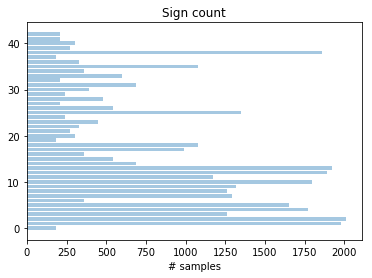

35


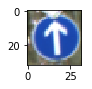

In [3]:
### Data exploration visualization goes here.

import matplotlib.pyplot as plt
import random
import scipy.ndimage

# Visualizations will be shown in the notebook.
%matplotlib inline
label_freq = np.bincount(y_train)
max_inputs = np.max(label_freq)

plt.barh(np.arange(n_classes), label_freq, align='center', alpha=0.4)

plt.xlabel('# samples')
plt.title('Sign count')

plt.show()

index = random.randint(0, len(X_train))
image = X_train[index]
plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

In [4]:
# retrieve class labels 
import csv
with open('signnames.csv', 'r') as file:
    reader = csv.reader(file)
    class_names = dict(reader)
    
# take a random sample per class
sample_image_per_class = []
for n in range(n_classes):
    sample_image_per_class.append(np.random.choice(np.where(y_train==n)[0]))
    
show_images = X_train[sample_image_per_class,:,:,:]

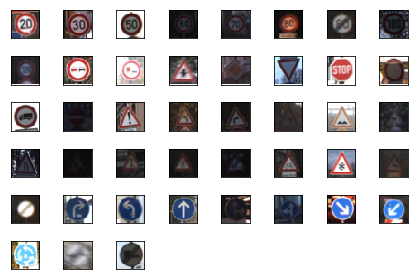

In [5]:
#show sign per class
def show_signs(image_array, width, height):
    fig = plt.figure()
    for j in range(image_array.shape[0]):
        ax = fig.add_subplot(height, width, j+1)
        ax.imshow(image_array[j], cmap='gray')
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.tight_layout()
    
show_signs(show_images, 8, 6)

In [ ]:
# show image of 10 random data points

import random

%matplotlib inline

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

<img src="random">



Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the German Traffic Sign Dataset.
There are various aspects to consider when thinking about this problem: Neural network architecture Play around preprocessing techniques (normalization, rgb to grayscale, etc)
Number of examples per label (some have more than others). 

In [ ]:
def read_label_names(filename):
    with open(filename, newline='', encoding="utf8") as csvfile:
        spamreader = csv.reader(csvfile)
        vals = [x[1] for x in spamreader][1:]
        return vals

label_names = read_label_names('signnames.csv')

def show_samples(n_samples, images, labels, randomize = False):
    # Show a random sign with its label
    for sample_n in range(n_samples):
#         n = 1
#         while y_train_input[n] != 21:
        if randomize:
            n = random.randint(0, len(images))
        else:
            n = sample_n
        ax = plt.subplot(np.ceil(n_samples/3),3,sample_n+1)
        ax.set_title(label_names[labels[n]], fontsize=10)
        ax.imshow(images[n])
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.tight_layout()
    plt.show()
    

def print_train_labels_count():
    print()
    print("Samples distribution:")
    print("%-50s%-32s" % ("Label", "|Count"))
    histogram = np.histogram(y_train, bins=np.arange(43))
    for i in range(len(histogram[0])):
        print("%-50s|%-32d" % (label_names[histogram[1][i]], histogram[0][i]))
        
print()
print("Random samples:")
show_samples(12, X_train, y_train, randomize = True)

print_train_labels_count()

Samples distribution:
Label                                             |Count                          
Speed limit (20km/h)                              |180                             
Speed limit (30km/h)                              |1980                            
Speed limit (50km/h)                              |2010                            
Speed limit (60km/h)                              |1260                            
Speed limit (70km/h)                              |1770                            
Speed limit (80km/h)                              |1650                            
End of speed limit (80km/h)                       |360                             
Speed limit (100km/h)                             |1290                            
Speed limit (120km/h)                             |1260                            
No passing                                        |1320                            
No passing for vehicles over 3.5 metric tons      |1800                            
Right-of-way at the next intersection             |1170                            
Priority road                                     |1890                            
Yield                                             |1920                            
Stop                                              |690                             
No vehicles                                       |540                             
Vehicles over 3.5 metric tons prohibited          |360                             
No entry                                          |990                             
General caution                                   |1080                            
Dangerous curve to the left                       |180                             
Dangerous curve to the right                      |300                             
Double curve                                      |270                             
Bumpy road                                        |330                             
Slippery road                                     |450                             
Road narrows on the right                         |240                             
Road work                                         |1350                            
Traffic signals                                   |540                             
Pedestrians                                       |210                             
Children crossing                                 |480                             
Bicycles crossing                                 |240                             
Beware of ice/snow                                |390                             
Wild animals crossing                             |690                             
End of all speed and passing limits               |210                             
Turn right ahead                                  |599                             
Turn left ahead                                   |360                             
Ahead only                                        |1080                            
Go straight or right                              |330                             
Go straight or left                               |180                             
Keep right                                        |1860                            
Keep left                                         |270                             
Roundabout mandatory                              |300                             
End of no passing                                 |420   


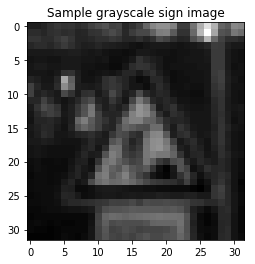

In [6]:
import cv2
from copy import deepcopy

#convert the images to grayscale
X_train_gr = [cv2.cvtColor(X_train[n], cv2.COLOR_BGR2GRAY)
              for n in range(np.shape(X_train)[0])]
X_test_gr = [cv2.cvtColor(X_test[n], cv2.COLOR_BGR2GRAY)
             for n in range(np.shape(X_test)[0])]
    
y_train_gr = deepcopy(y_train)

plt.imshow(random.choice(X_train_gr), cmap='gray')
plt.title('Sample grayscale sign image')
plt.show()


**Question 1: Describe how, and identify where in your code, you preprocessed the image data.  What techniques were chosen and why.**

For Data Reduction, I converted the images from RGB to grayscale - that way we don't have to preprocess the image with all three color channels seperately. 

Also I one-hot encoded the labels to make computing the cross entropy for the loss function possible. 

**Question 2
Describe how you set up the training, validation and testing data for your model.**

I built the validation set choosing 25% random data then added additional data, applying these methods: skew, perspective transforms and rotation.

In [7]:
# functions to transform the images
# trasformation 1
def trans_1(image):
    pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts2 = np.float32([[0,0],[32,5],[0,32],[32,27]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(image,M,(32,32))
    return dst

# trasformation 2
def trans_2(image):
    pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts2 = np.float32([[0,5],[32,0],[0,27],[32,32]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(image,M,(32,32))
    return dst

# trasformation 3
def trans_3(image):
    pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts2 = np.float32([[5,0],[27,0],[0,32],[32,32]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(image,M,(32,32))
    return dst

# trasformation 4 - skew image 1
def trans_4(image):
    pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts2 = np.float32([[0,0],[27,5],[5,32],[32,27]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(image,M,(32,32))
    return dst

# trasformation 5 - skew image 2
def trans_5(image):
    pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts2 = np.float32([[5,5],[32,0],[0,27],[27,32]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(image,M,(32,32))
    return dst

# transformation 6 - rotation +5 to +15
def trans_6(image):
    # chose rotation angle randomly from a uniform distribution
    rot_ang = int(np.random.uniform(10)) + 5
    M = cv2.getRotationMatrix2D((16,16),rot_ang,1)
    dst = cv2.warpAffine(image,M,(32,32))
    return dst## visualize the transformations to be performed on the dataset


# transformation 7 - rotation -5 to -15
def trans_7(image):

    # chose rotation angle randomly from a uniform distribution
    rot_ang = int(np.random.uniform(-10)) - 5
    M = cv2.getRotationMatrix2D((16,16),rot_ang,1)
    dst = cv2.warpAffine(image,M,(32,32))
    return dst

Transformations performed for data augmentation:


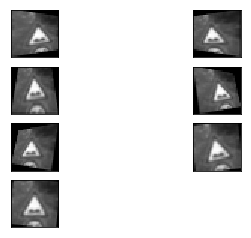

In [8]:
## visualize the transformations to be performed on the dataset
sample_im = random.choice(X_train_gr)

transformations = [trans_1, trans_2, trans_3, trans_4, trans_5, trans_6, trans_7]

for i, tr in enumerate(transformations):
    transformed = tr(sample_im)
    plt.subplot(4,2,i+1)
    plt.imshow(transformed, cmap='gray')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

print('Transformations performed for data augmentation:')

In [9]:
# global variable to keep all original dataset and add augmented dataset
all_X_train = deepcopy(X_train_gr)
all_y_train = deepcopy(y_train_gr)
    
## use data augmentation to beef up classes that has low frequencies

# augment data function:
def augment_data(augment_fn, X_data,y_data):
    global all_X_train
    global all_y_train
   
    print('old shape:')
    print(np.shape(all_y_train))

    class_freq = np.bincount(all_y_train)

    mean_freq = int(np.average(class_freq))
    print('mean frequency:', mean_freq)

    transform_X = []
    transform_y = []
    for i, im in enumerate(X_data):
        if class_freq[y_data[i]] < mean_freq:
            im_trans = augment_fn(im)
            transform_X.append(im)
            transform_y.append(y_data[i])

    all_X_train = np.append(all_X_train, transform_X, axis=0)
    all_y_train = np.append(all_y_train, transform_y, axis=0)

    print('new shape:')
    print(np.shape(all_X_train))
    print(np.shape(all_y_train))

    class_freq = np.bincount(all_y_train)
    display_image_id = 1000

    plt.figure(1)
    n = np.size(class_freq)

    index = np.arange(np.shape(class_freq)[0])
    plt.bar(index, class_freq, 1)
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.show

old shape:
(34799,)
mean frequency: 809
new shape:
(43918, 32, 32)
(43918,)
old shape:
(43918,)
mean frequency: 1021
new shape:
(50968, 32, 32)
(50968,)
old shape:
(50968,)
mean frequency: 1185
new shape:
(60508, 32, 32)
(60508,)
old shape:
(60508,)
mean frequency: 1407
new shape:
(73077, 32, 32)
(73077,)
old shape:
(73077,)
mean frequency: 1699
new shape:
(81417, 32, 32)
(81417,)
old shape:
(81417,)
mean frequency: 1893
new shape:
(93866, 32, 32)
(93866,)
old shape:
(93866,)
mean frequency: 2182
new shape:
(110996, 32, 32)
(110996,)


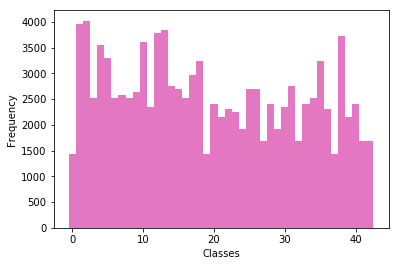

In [10]:
# augmentation 
augment_data(trans_1, X_train_gr, y_train_gr)
augment_data(trans_2, X_train_gr, y_train_gr)
augment_data(trans_3, X_train_gr, y_train_gr)
augment_data(trans_4, X_train_gr, y_train_gr)
augment_data(trans_5, X_train_gr, y_train_gr)
augment_data(trans_6, X_train_gr, y_train_gr)
augment_data(trans_7, X_train_gr, y_train_gr)

In [11]:
# empty arrays for new training and validation datasets
new_X_train = []
new_y_train = []

new_X_val = []
new_y_val = []

for n in range(n_classes):
    # find indexes of each classes in the dataset
    # randomly choose from and make up a validation set for each class
    where_id = np.where(all_y_train==n)[0]
    np.random.shuffle(where_id)
    
    # make training data 80% of orginal dataset
    cut_off = 0.75
    new_X_train.append(all_X_train[where_id][:int(np.shape(where_id)[0]*cut_off)])
    new_X_val.append(all_X_train[where_id][int(np.shape(where_id)[0]*cut_off):])
    
    new_y_train.append(all_y_train[where_id][:int(np.shape(where_id)[0]*cut_off)])
    new_y_val.append(all_y_train[where_id][int(np.shape(where_id)[0]*cut_off):])
else:
    # stack up training and validation sets
    new_X_train = np.vstack(new_X_train)
    new_X_val = np.vstack(new_X_val)
    new_y_train = np.hstack(new_y_train)
    new_y_val = np.hstack(new_y_val)
    
# confirm shape of datasets made
print('shape of training data',np.shape(new_X_train))
print('shape of validation data', np.shape(new_X_val))

shape of training data (83245, 32, 32)
shape of validation data (27751, 32, 32)


In [12]:
print('Creating network architecture...')
import tensorflow as tf
from tensorflow.contrib.layers import flatten

# inputs and parameters
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

# keep probability for dropout
keep_prob = tf.placeholder(tf.float32)

# one-hot encode the labels
one_hot_y = tf.one_hot(y, 43)

# learning rate
l_rate = 0.001

Creating network architecture...


**Question 3 What does your final architecture look like?**

mu = 0 sigma = 0.1 Number of convolutional layers - 3 Number of fully connected layers - 2 

**Layer 1:**
Convolution of 5x5 kernel, 1 stride, 24 feature maps.  Activation: ReLU Pooling 1: 2x2 kernel and 2 stride.

**Layer 2:**
Convolution of 3x3 kernel, 1 stride and 32 feature maps Activation: ReLU Pooling 2: 2X2 kernel and 2 stride

**Layer 3:** 
Fully connected layer with 512 units. ReLU activation

**Layer 4:** Fully connnected with 256 units Activation: ReLU 
Output Layer: Fully connected with 43 units for logits output. Activation: Softmax

In [13]:
# define archtecture
def signs_classify(x, keep_prob):
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 24), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(24))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation 1.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x32. Output = 14x14x32.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 12x12x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 24, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation 2.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 14x14x32. Output = 7x7x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 3: Convolutional. Output = 7x7x64.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(64))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    
    # Activation 3.
    conv3 = tf.nn.relu(conv3)

    # Pooling. Input = 5x5x64. Output = 2x2x64.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 2x2x64. Output = 256.
    fc0   = flatten(conv3)
    
    # Layer 3: Fully Connected. Input = 256. Output = 512.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(256, 512), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(512))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation 3.
    fc1    = tf.nn.relu(fc1)
    
    # dropout 1
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 512. Output = 256.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(512, 256), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(256))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation 4.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Output Layer: Fully Connected. Input = 256. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(256, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


**Training Pipeline**

**Question 4. How did you train your model?**

Adam optimizer with 0.001 Batch size. 128 Epochs and 15 Hyperparameters. Mean = 0; Standard Deviation of 0.1


In [14]:
# training functions
logits = signs_classify(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
# compute the mean over all samples
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = l_rate)
training_operation = optimizer.minimize(loss_operation)

**Question 5 What approach did you take in coming with a solution to this problem?**

I used the Adam Optimizer because it performed well being adaptive.  With lower epochs, was able to obtain high accuracy. Used dropout of 0.5 for training and 1.0 for validation to prevent overfitting.

In [15]:
# model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data, drop_out):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: drop_out})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [16]:
# reshape dataset to suitable input for network
new_X_train = np.reshape(new_X_train, (np.shape(new_X_train)[0],32,32,1))
new_X_val = np.reshape(new_X_val, (np.shape(new_X_val)[0],32,32,1))

# normalize dataset [naive]
new_X_train = (np.array(new_X_train) - 128.0)/256.0
new_X_val = (np.array(new_X_val) - 128.0)/256.0

In [17]:
from sklearn.utils import shuffle

save_file = './sign_classify.ckpt'
EPOCHS = 15
BATCH_SIZE = 128
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(new_X_train, new_y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
            
        validation_accuracy = evaluate(new_X_val, new_y_val, drop_out=1.0)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, save_file)
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.839

EPOCH 2 ...
Validation Accuracy = 0.950

EPOCH 3 ...
Validation Accuracy = 0.973

EPOCH 4 ...
Validation Accuracy = 0.983

EPOCH 5 ...
Validation Accuracy = 0.987

EPOCH 6 ...
Validation Accuracy = 0.990

EPOCH 7 ...
Validation Accuracy = 0.990

EPOCH 8 ...
Validation Accuracy = 0.996

EPOCH 9 ...
Validation Accuracy = 0.996

EPOCH 10 ...
Validation Accuracy = 0.996

EPOCH 11 ...
Validation Accuracy = 0.996

EPOCH 12 ...
Validation Accuracy = 0.997

EPOCH 13 ...
Validation Accuracy = 0.996

EPOCH 14 ...
Validation Accuracy = 0.996

EPOCH 15 ...
Validation Accuracy = 0.998

Model saved


In [18]:
new_X_test = np.reshape(X_test_gr, (np.shape(X_test_gr)[0],32,32,1))

# normalize dataset [naive]
new_X_test = (np.array(new_X_test) - 128.0)/256.0

meta_graph_file = save_file+'.meta'

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(meta_graph_file)
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    # model evaluation
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    test_accuracy = sess.run(
        accuracy_operation,
        feed_dict={x: new_X_test, y: y_test, keep_prob: 1.0})

print('Test Accuracy: {}'.format(test_accuracy))

Test Accuracy: 0.9456848502159119


# Step 3: Test a Model on New Images

**Question 6
Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook.**


(268, 270, 1)
(270, 280, 1)


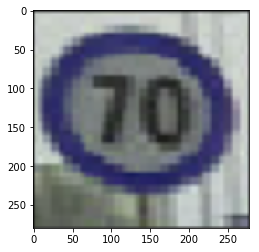

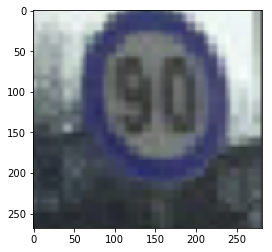

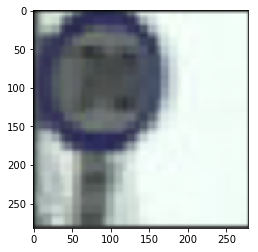

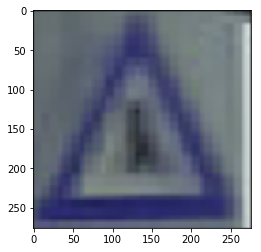

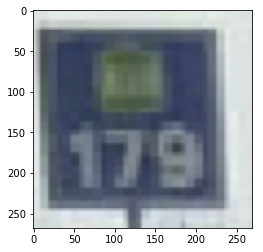

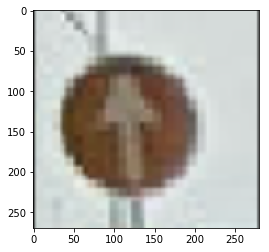

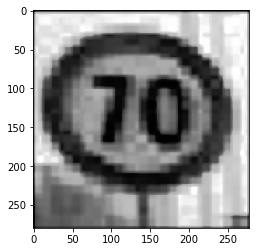

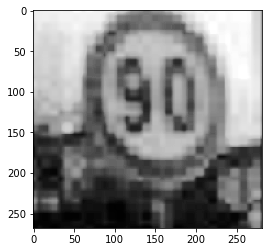

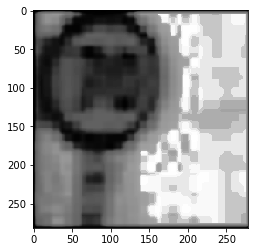

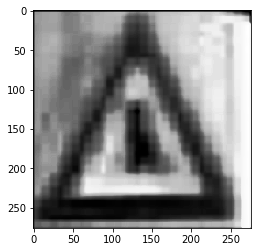

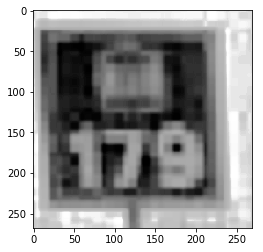

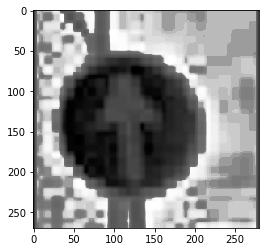

In [155]:

image1 = cv2.imread("Real-World/1.png")
plt.imshow(image1[:,:])
plt.figure()
image2 = cv2.imread("Real-World/2.png")
plt.imshow(image2[:,:])
plt.figure()
image3 = cv2.imread("Real-World/3.png")
plt.imshow(image3[:,:])
plt.figure()
image4 = cv2.imread("Real-World/4.png")
plt.imshow(image4[:,:])
plt.figure()
image5 = cv2.imread("Real-World/5.png")
plt.imshow(image5)
plt.figure()
image5 = cv2.imread("Real-World/6.png")
plt.imshow(image5)
plt.figure()

### Load the images and plot them here.
### Feel free to use as many code cells as needed.
image1 = cv2.imread("Real-World/1.png",0)
image1 = cv2.equalizeHist(image1)
image1 = np.expand_dims(image1, axis=2)
cv2.imwrite(str(path)+"Sign1.png",image1)
plt.imshow(image1[:,:,0], cmap='gray')
plt.figure()

image2 = cv2.imread("Real-World/2.png",0)
image2 = cv2.equalizeHist(image2)
image2 = np.expand_dims(image2, axis=2)
cv2.imwrite(str(path)+"Sign2.png",image2)
plt.imshow(image2[:,:,0], cmap='gray')
plt.figure()

image3 = cv2.imread("Real-World/3.png",0)
image3 = cv2.equalizeHist(image3)
image3 = np.expand_dims(image3, axis=2)
cv2.imwrite(str(path)+"Sign3.png",image3)
plt.imshow(image3[:,:,0], cmap='gray')
plt.figure()

image4 = cv2.imread("Real-World/4.png",0)
image4 = cv2.equalizeHist(image4)
image4 = np.expand_dims(image4, axis=2) 
cv2.imwrite(str(path)+"Sign4.png",image4)
plt.imshow(image4[:,:,0], cmap='gray')
plt.figure()

image5 = cv2.imread("Real-World/5.png",0)
image5 = cv2.equalizeHist(image5)
image5 = np.expand_dims(image5, axis=2)
cv2.imwrite(str(path)+"Sign5.png",image5)
print(image5.shape)
plt.imshow(image5[:,:,0], cmap='gray')
plt.figure()


image5 = cv2.imread("Real-World/6.png",0)
image5 = cv2.equalizeHist(image5)
image5 = np.expand_dims(image5, axis=2)
cv2.imwrite(str(path)+"Sign5.png",image5)
print(image5.shape)
plt.imshow(image5[:,:,0], cmap='gray')
plt.figure()

In [ ]:
import os

no_of_imgs = 6
disp_imgs = []
disp_imgs_gray = []

for i in os.listdir('sign_italy/'):
    image = cv2.imread('sign_italy/'+i)
    dim = (32,32)

    # convert to grayscale
    grayed = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    disp_imgs.append(np.asarray(grayed))
    
    grayed = cv2.cvtColor(grayed, cv2.COLOR_RGB2GRAY)
    
    disp_imgs_gray.append(np.asarray(grayed))

show_signs(np.array(disp_imgs), 4,4)

# normalize new test data
test_imgs_gray = ((np.array(disp_imgs_gray)-128.0)/256.0).reshape(no_of_imgs,32,32,1)

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(meta_graph_file)
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    # model evaluation
    prediction = tf.argmax(logits, 1)

    test_prediction = sess.run(
        prediction,
        feed_dict={x: test_imgs_gray, keep_prob: 1.0})
for i in range(no_of_imgs):
    print('Prediction: {} \t| {}'.format(test_prediction[i], 
                                    
                                            class_names[str(test_prediction[i])]))

<img style="float: left;" src="siximages">



Prediction: 1 	| Speed limit (30km/h)  
Prediction: 39 	| Keep left  
Prediction: 26 	| Traffic signals    
Prediction: 11 	| Right-of-way at the next intersection  
Prediction: 18 	| General caution  
Prediction: 34 	| Turn left ahead  


In [ ]:
# get the softmax probabilities for n best prediction probabilities.
predict_no = 5
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('sign_classify.ckpt.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    # model evaluation
    prediction = tf.nn.softmax(logits)

    test_prediction = sess.run(tf.nn.top_k(
        prediction,k=predict_no),
        feed_dict={x: test_imgs_gray , keep_prob: 1.0})

# print('Predictions: {}'.format(test_prediction))

In [ ]:
# plot visualization of softmax probabilities
index = np.arange(predict_no)
probabilities, predict_classes = test_prediction

candidates = [1,2,3,4,5]
for i,im in enumerate(candidates):
    fig = plt.figure(figsize=(20, 20)) 
    plt.subplot(5,2,(i+1)*2-1)
    plt.imshow(disp_imgs[im])
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

    
    plt.subplot(5,2,(i+1)*2)
    plt.barh(index, probabilities[im], align='center')
    plt.yticks(index,[class_names[str(predict_classes[im][i])] for i in index] )
#     plt.axis([0,1,-0.5,2.5])

plt.tight_layout()

<img src="unknown-11">  

 <img src="unknown-7">  

<img src="unknown-8"> 

 <img src="unknown-9">  

<img src="unknown-10">

**Question 7**
Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate.

In the test set, the accuracy was 95%, but in the captured images, the accuracy was only 20% (1 out of 5)

**Question 8**

Use the model's softmax probabilities to visualize the certainty of its predictions, tf.nn.top_k could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)

Image 1: Model failed completely.   
Image 2: Model failed completely  
Image 3: Model passed: "Right of way at next intersection"  
Image 4: Model failed. 
Image 5: Model failed completely
